In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
train_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/datasets',
                                 train=True,
                                 transform=transforms.ToTensor(),
                                 download=False)

test_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/datasets',
                                 train=False,
                                 transform=transforms.ToTensor(),
                                 download=False)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset, test_dataset = torch.utils.data.random_split(
    test_dataset, [int(0.9*len(test_dataset)), int(0.1*len(test_dataset))])

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

In [ ]:
class LeNet5 (nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                               kernel_size=(5,5),
                               stride=(1,1),
                               padding=(0,0))

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                               kernel_size=(5,5),
                               stride=(1, 1),
                               padding=(0, 0))

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120,
                               kernel_size=(5,5),
                               stride=(1, 1),
                               padding=(0, 0))

        self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 184)
        self.fc2 = nn.Linear(184, num_classes)
        self.flatten = nn.Flatten()

    def forward(self, X):
        input_layer = self.relu(self.conv1(X))
        out = self.pool(input_layer)
        out = self.relu(self.conv2(out))
        out = self.pool(out)
        out = self.relu(self.conv3(out))
        # out = out.reshape(out.shape[0], -1)
        out = self.flatten(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [ ]:
model = LeNet5(num_classes=10)

model.conv1 = nn.Conv2d(in_channels=3,
                        out_channels=6,
                        kernel_size=(5,5),
                        stride=(1,1),
                        padding=(0,0))

model = model.to(device)

print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=184, bias=True)
  (fc2): Linear(in_features=184, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 50
start = time.time()
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        z_scores = model(images)
        loss = criterion(z_scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predictions = torch.max(z_scores, 1)
        running_corrects += torch.sum(predictions == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    print(f'Epoch {epoch+1} / {num_epochs}, '
          f'Train Loss {epoch_loss:.4f}, '
          f'Train Acc {epoch_acc:.4f}')

    train_acc_hist.append(epoch_acc)
    loss_train.append(epoch_loss)

    step_lr_scheduler.step()

    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            z_scores = model(images)
            loss = criterion(z_scores, labels)

            running_loss += loss.item() * images.size(0)
            _, predictions = torch.max(z_scores, 1)
            running_corrects += torch.sum(predictions == labels)

    epoch_loss_val = running_loss / len(val_dataset)
    epoch_acc_val = running_corrects / len(val_dataset)
    print(f'Epoch {epoch + 1} / {num_epochs}, '
          f'Val Loss {epoch_loss_val:.4f}, '
          f'Val Acc {epoch_acc_val:.4f}')

    val_acc_hist.append(epoch_acc_val)
    loss_val.append(epoch_loss_val)

    if epoch_acc_val > best_acc:
        best_acc = epoch_acc_val

time_elapsed = time.time() - start

Epoch 1 / 50, Train Loss 1.7566, Train Acc 0.3553
Epoch 1 / 50, Val Loss 1.5192, Val Acc 0.4456
Epoch 2 / 50, Train Loss 1.4636, Train Acc 0.4692
Epoch 2 / 50, Val Loss 1.3794, Val Acc 0.4963
Epoch 3 / 50, Train Loss 1.3483, Train Acc 0.5146
Epoch 3 / 50, Val Loss 1.3392, Val Acc 0.5180
Epoch 4 / 50, Train Loss 1.2698, Train Acc 0.5435
Epoch 4 / 50, Val Loss 1.2632, Val Acc 0.5460
Epoch 5 / 50, Train Loss 1.2141, Train Acc 0.5662
Epoch 5 / 50, Val Loss 1.2375, Val Acc 0.5587
Epoch 6 / 50, Train Loss 1.1633, Train Acc 0.5853
Epoch 6 / 50, Val Loss 1.2138, Val Acc 0.5742
Epoch 7 / 50, Train Loss 1.1208, Train Acc 0.6006
Epoch 7 / 50, Val Loss 1.2160, Val Acc 0.5730
Epoch 8 / 50, Train Loss 1.0179, Train Acc 0.6387
Epoch 8 / 50, Val Loss 1.1513, Val Acc 0.5963
Epoch 9 / 50, Train Loss 1.0006, Train Acc 0.6466
Epoch 9 / 50, Val Loss 1.1452, Val Acc 0.5966
Epoch 10 / 50, Train Loss 0.9916, Train Acc 0.6502
Epoch 10 / 50, Val Loss 1.1449, Val Acc 0.5968
Epoch 11 / 50, Train Loss 0.9847, Trai

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
calculate_time(time_elapsed)

Training complete in 9m 19s


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/lenet_on_cifar.pth')

In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.6024


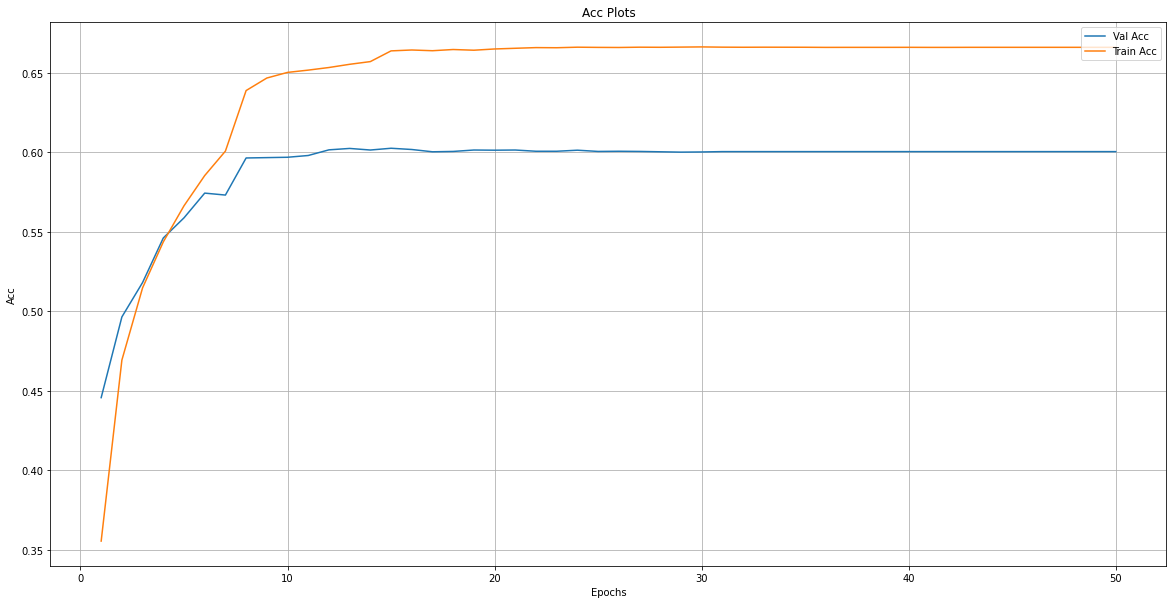

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

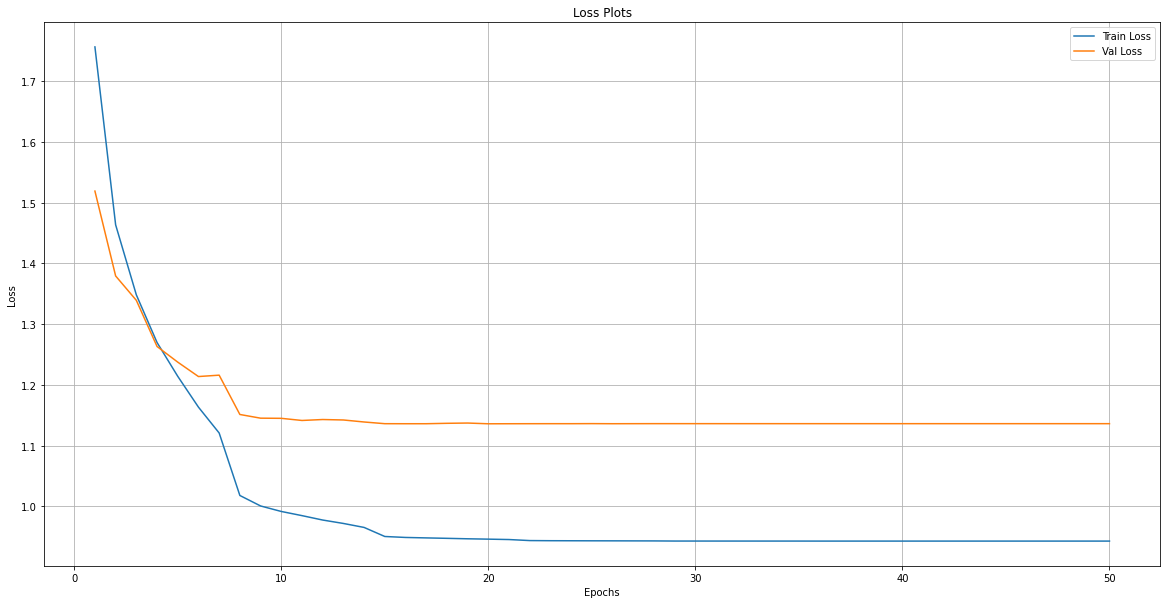

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.5880
